# Withdrawals Queue replacement Simulation


In [1]:
from pathlib import Path
from datetime import datetime
from collections import defaultdict

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns

from IPython.display import display, Markdown
from model.types.proposals import Proposal
from model.types.proposal_type import ProposalSubType, ProposalType
from model.utils.postprocessing import postprocessing
from model.utils.simulation import merge_simulation_results, save_execution_result, setup_simulation
from model.types.proposal_type import ProposalGeneration
from model.types.scenario import Scenario

out_path = Path("results/simulations/withdrawal_queue_attack06.09.24.14.39")
out_path.mkdir(exist_ok=True)

In [2]:
pd.options.display.float_format = "{:.2f}".format
%matplotlib inline

### Simulation parameters


In [3]:
MONTE_CARLO_RUNS = 10
TIMESTEPS = 120
SEED = 141412
SIMULATION_TIME = datetime(2024, 9, 1)
SCENARIO = Scenario.SingleAttack

proposals = [
    Proposal(
        timestep=2,
        damage=100,
        proposal_type=ProposalType.Danger,
        sub_type=ProposalSubType.FundsStealing,
        proposer="0x98078db053902644191f93988341e31289e1c8fe",
        attack_targets={
            "0xb671e841a8e6db528358ed385983892552ef422f",
            "0x4b4eec1ddc9420a5cc35a25f5899dc5993f9e586",
            "0x47176b2af9885dc6c4575d4efd63895f7aaa4790",
        },
    ),
]

attackers = {"0x98078db053902644191f93988341e31289e1c8fe", "0xc329400492c6ff2438472d4651ad17389fcb843a"}
defenders = {"0x3e40d73eb977dc6a537af587d48316fee66e9c8c"}

### Configuration


In [4]:
experiment, simulation_hashes = setup_simulation(
    timesteps=TIMESTEPS,
    monte_carlo_runs=MONTE_CARLO_RUNS,
    scenario=SCENARIO,
    proposal_types=ProposalType.Danger,
    proposal_subtypes=ProposalSubType.FundsStealing,
    proposals_generation=ProposalGeneration.Random,
    proposals=proposals,
    attackers=attackers,
    defenders=defenders,
    seed=SEED,
    simulation_starting_time=SIMULATION_TIME,
    out_dir=out_path,
)
experiment.after_experiment = lambda experiment=None: save_execution_result(experiment, TIMESTEPS, out_path)

### Execution


In [5]:
simulations = experiment.get_simulations()
if len(simulations) != 0:
    experiment.run()

result = merge_simulation_results(simulation_hashes, out_path)

submitting proposal with ID 1 at  2024-09-01 03:00:00
Proposal(id=1, timestep=2, damage=100, proposer='0x98078db053902644191f93988341e31289e1c8fe', proposal_type=<ProposalType.Danger: 4>, sub_type=<ProposalSubType.FundsStealing: 2>, attack_targets={'0x4b4eec1ddc9420a5cc35a25f5899dc5993f9e586', '0x47176b2af9885dc6c4575d4efd63895f7aaa4790', '0xb671e841a8e6db528358ed385983892552ef422f'})
9  attackers in the system that is going to steal  140661570039999992168448  stETH and  0  wstETH
stealing from honest actors  1.4066157004e+23  stETH and  0.0  wstETH
Proposal(id=1, timestep=2, damage=100, proposer='0x98078db053902644191f93988341e31289e1c8fe', proposal_type=<ProposalType.Danger: 4>, sub_type=<ProposalSubType.FundsStealing: 2>, attack_targets={'0x4b4eec1ddc9420a5cc35a25f5899dc5993f9e586', '0x47176b2af9885dc6c4575d4efd63895f7aaa4790', '0xb671e841a8e6db528358ed385983892552ef422f'})
need to cancel proposals
[1]
actor_reset_proposal_effect [1]
submitting proposal with ID 1 at  2024-09-01 03:0

### Plots

#### Processing

In [6]:
def open_actors_csv(simulation_hashes: list[str], out_path: Path):
    dfs: list = []
    simulation_counter = 0

    for hash in simulation_hashes:
        folder_path = out_path.joinpath(f"{hash}/")
        actors_file = folder_path / "actors.csv"

        actors_df = pd.read_csv(actors_file)

        actors_df["simulation"] = simulation_counter
        dfs.append(actors_df)
        simulation_counter += 1

    combined_df = pd.concat(dfs, ignore_index=True)

    return combined_df


post_processing = postprocessing(result)
actors_df = open_actors_csv(simulation_hashes, out_path)

In [7]:
actors_df["total_coins_balance"] = actors_df.wstETH_balance + actors_df.st_eth_balance
actors_df["total_coins_locked"] = actors_df.wstETH_locked + actors_df.st_eth_locked
actors_df["actor_locked"] = actors_df["total_coins_locked"] > 0
actors_df["actor_locked"] = actors_df["total_coins_locked"] > 0
total_actors = len(actors_df.id.unique())

sum_by_actors = actors_df.groupby(by=["seed", "timestep"]).sum(numeric_only=True).reset_index()
sum_by_actors.drop(columns=["id", "last_locked_tx_timestamp"], inplace=True)
actors_df = actors_df.merge(sum_by_actors, on=["seed", "timestep"], suffixes=("", "_sum"))

actors_df["total_coins_balance_relative"] = (
    actors_df["total_coins_balance"] / actors_df["total_coins_balance_sum"]
).replace(np.nan, 0)
actors_df["total_coins_locked_relative"] = (
    actors_df["total_coins_locked"] / actors_df["total_coins_balance_sum"]
).replace(np.nan, 0)
actors_df["actor_locked_relative"] = actors_df["actor_locked"] / total_actors
actors_df["health_relative"] = actors_df["health"] / actors_df["initial_health_sum"]
actors_df["count"] = 1

In [8]:
result.columns

Index(['actors', 'lido', 'dual_governance', 'proposals',
       'non_initialized_proposals', 'time_manager', 'scenario', 'attackers',
       'defenders', 'proposal_types', 'proposal_subtypes', 'is_active_attack',
       'proposal_generation', 'seed', 'simulation', 'subset', 'run', 'substep',
       'timestep'],
      dtype='object')

In [9]:
result['dg_state'] = result.dual_governance.apply(lambda x: x.state.state)
result['dg_state_value'] = result['dg_state'].apply(lambda state: state.value)
result['dg_state_name'] = result['dg_state'].apply(lambda state: state.name)

In [10]:
result['dg_dynamic_timelock_hours'] = result.dual_governance.apply(lambda dg: dg.state._calc_dynamic_timelock_duration(dg.state.signalling_escrow.get_rage_quit_support()).to_seconds() / 60 / 60 / 24)

In [11]:
actors_df_summed_by_actors = actors_df.groupby(by=['seed', 'timestep']).sum(numeric_only=True).reset_index()
actors_df_summed_by_actors_rts = actors_df.groupby(by=['seed', 'timestep', 'reaction_time'], sort=False).sum(numeric_only=True).reset_index()

#### General plot

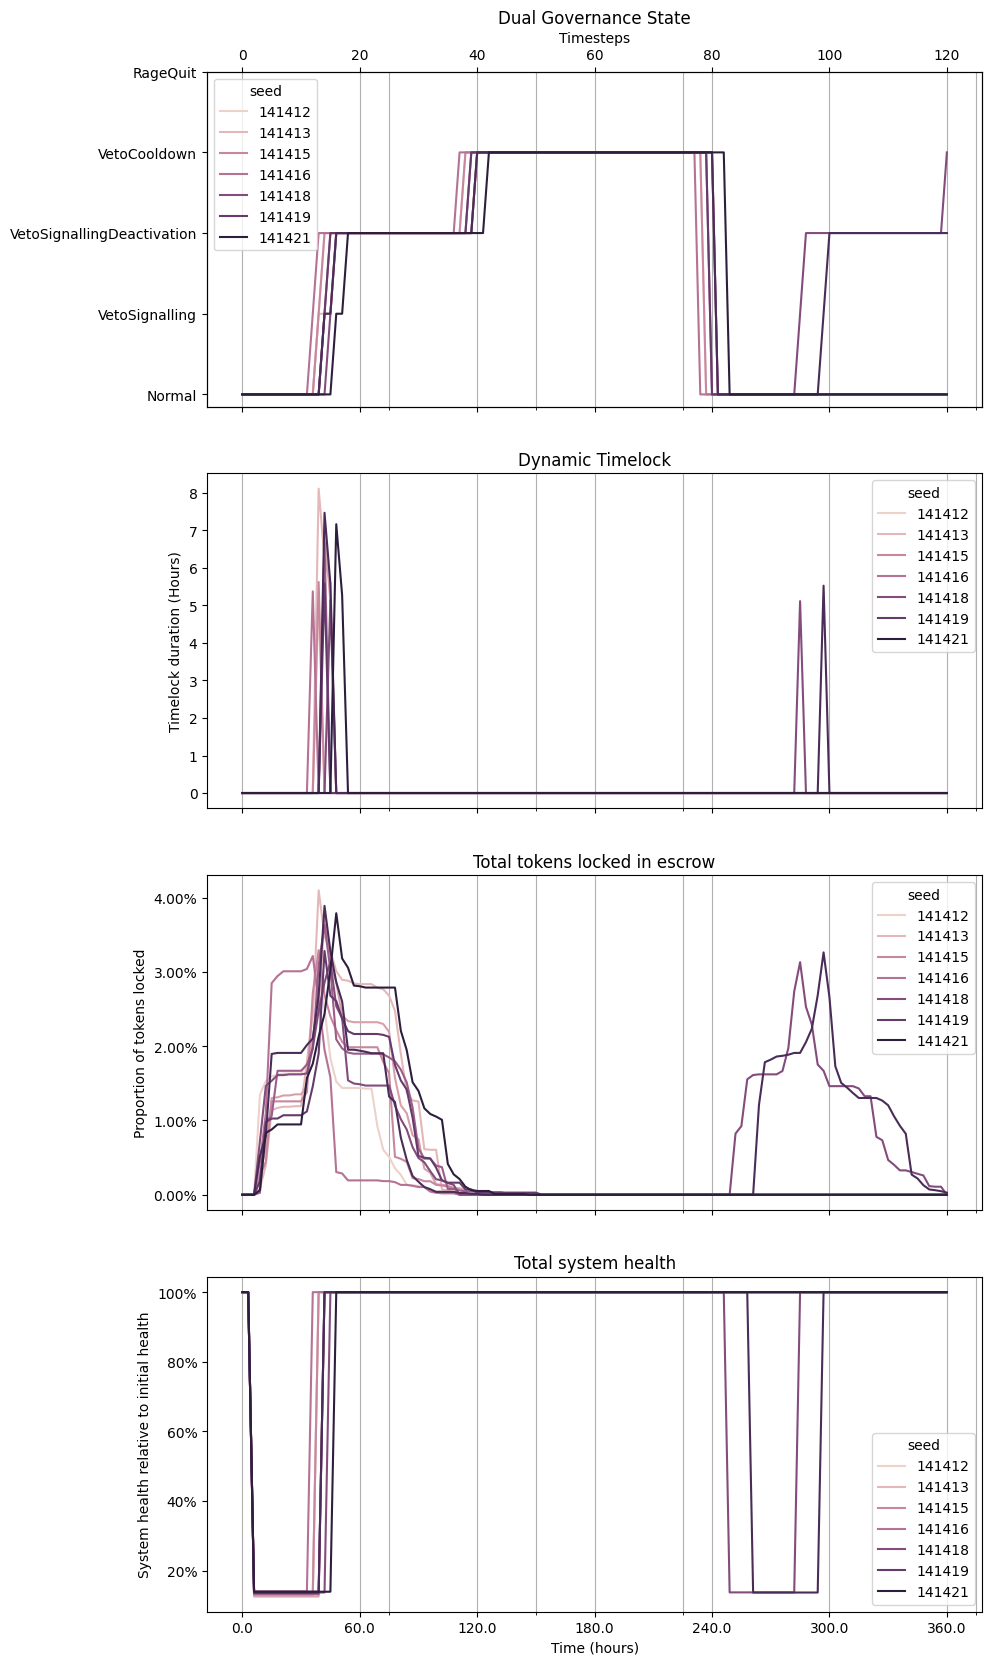

In [12]:
basesize = 5
n_plots = 4
fig, axes = plt.subplots(figsize=(basesize * 2, basesize * n_plots), nrows=n_plots, sharex=True)
sns.lineplot(result, x='timestep', y='dg_state_value', hue='seed', ax=axes[0])
state_names = {1: 'Normal', 2: 'VetoSignalling', 3: 'VetoSignallingDeactivation', 4: 'VetoCooldown', 5: 'RageQuit'}
axes[0].set_yticks(list(state_names.keys()), labels=list(state_names.values()));
axes[0].set_ylabel('');
axes[0].set_title('Dual Governance State')

sns.lineplot(result, x='timestep', y='dg_dynamic_timelock_hours', hue='seed', ax=axes[1])
axes[1].set_ylabel('Timelock duration (Hours)');
axes[1].set_title('Dynamic Timelock')

sns.lineplot(actors_df_summed_by_actors, x='timestep', y='total_coins_locked_relative', hue='seed', ax=axes[2])
axes[2].set_title('Total tokens locked in escrow')
axes[2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
axes[2].set_ylabel('Proportion of tokens locked')

sns.lineplot(actors_df_summed_by_actors, x='timestep', y='health_relative', hue='seed', ax=axes[3])
axes[3].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
axes[3].set_title('Total system health')
axes[3].set_ylabel('System health relative to initial health')

axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))
axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(25))
axes[-1].set_xlabel('Time (hours)')

ax_twin = axes[0].twiny()
# ax2.grid(True)
ax_twin.set_xlabel('Timesteps')
ax_twin.set_xticks(axes[0].get_xticks())
ax_twin.set_xlim(axes[0].get_xlim())
for i in range(len(axes)):
    axes[i].grid(True, axis='x', which='both')

fig.savefig(out_path.joinpath('Lock dynamics' + '.png'), dpi=300)
fig.savefig(out_path.joinpath('Lock dynamics' + '.svg'), dpi=1000)

#### Individual plots

In [13]:
for seed in result.seed.unique():
    basesize = 5
    n_plots = 4
    fig, axes = plt.subplots(figsize=(basesize * 2, basesize * n_plots), nrows=n_plots, sharex=True)
    sns.lineplot(result[result['seed'] == seed], x='timestep', y='dg_state_value', ax=axes[0])
    state_names = {1: 'Normal', 2: 'VetoSignalling', 3: 'VetoSignallingDeactivation', 4: 'VetoCooldown', 5: 'RageQuit'}
    axes[0].set_yticks(list(state_names.keys()), labels=list(state_names.values()));
    axes[0].set_ylabel('');
    axes[0].set_title('Dual Governance State')
    
    sns.lineplot(result[result['seed'] == seed], x='timestep', y='dg_dynamic_timelock_hours', ax=axes[1])
    axes[1].set_ylabel('Timelock duration (Hours)');
    axes[1].set_title('Dynamic Timelock')
    
    sns.lineplot(actors_df_summed_by_actors[actors_df_summed_by_actors['seed'] == seed], x='timestep', y='total_coins_locked_relative', ax=axes[2])
    axes[2].set_title('Total tokens locked in escrow')
    axes[2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    axes[2].set_ylabel('Proportion of tokens locked')
    axes[2].yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
    axes[2].grid(True, axis='y', which='both')
    
    sns.lineplot(actors_df_summed_by_actors[actors_df_summed_by_actors['seed'] == seed], x='timestep', y='health_relative', ax=axes[3])
    axes[3].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    axes[3].set_title('Total system health')
    axes[3].set_ylabel('System health relative to initial health')

    ### proposals
    simulation_start = result[(result['seed'] == seed) & (result['timestep'] == 0)].time_manager.apply(lambda tm: tm.current_time).iloc[0].timestamp()
    proposals_info = result[result['seed'] == seed].dual_governance.apply(lambda dg: dg.timelock.proposals.state.proposals).iloc[-1]
    proposal_dict = defaultdict(list)
    for proposal in proposals_info:
        proposal_dict['id'].append(proposal.id)
        proposal_dict['status'].append(proposal.status)
        proposal_dict['submittedAt'].append((proposal.submittedAt.to_seconds() - simulation_start) / 3600 / 3)
        proposal_dict['scheduledAt'].append((proposal.scheduledAt.to_seconds() - simulation_start) / 3600 / 3)
        proposal_dict['executedAt'].append((proposal.executedAt.to_seconds() - simulation_start) / 3600 / 3)
    proposal_df = pd.DataFrame(proposal_dict).set_index('id')
    for i in range(n_plots):
        for proposal_id in proposal_df.index:
            prop = proposal_df.loc[proposal_id]
            ylim = axes[i].get_ylim()
            dy = (ylim[1] - ylim[0]) * 0.1
            axes[i].plot(np.repeat(prop.submittedAt, 2), [ylim[0], ylim[0] + dy], color='orange')
            axes[i].set_ylim(ylim)
        axes[i].plot([],[], color='orange', label='Proposal submittion')
        axes[i].legend()
    ### proposals
    
    axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))
    axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(25))
    axes[-1].set_xlabel('Time (hours)')
    
    ax_twin = axes[0].twiny()
    # ax2.grid(True)
    ax_twin.set_xlabel('Timesteps')
    ax_twin.set_xticks(axes[0].get_xticks())
    ax_twin.set_xlim(axes[0].get_xlim())
    for i in range(len(axes)):
        axes[i].grid(True, axis='x', which='both')
    
    fig.savefig(out_path.joinpath(f'Lock dynamics (seed={seed})' + '.png'), dpi=300)
    fig.savefig(out_path.joinpath(f'Lock dynamics (seed={seed})' + '.svg'), dpi=1000)
    plt.close(fig)

#### Individual plots broken down by ReactionTime (unfinished)

In [14]:
for seed in result.seed.unique():
    basesize = 5
    n_plots = 4
    fig, axes = plt.subplots(figsize=(basesize * 2, basesize * n_plots), nrows=n_plots, sharex=True)
    sns.lineplot(result[result['seed'] == seed], x='timestep', y='dg_state_value', ax=axes[0])
    state_names = {1: 'Normal', 2: 'VetoSignalling', 3: 'VetoSignallingDeactivation', 4: 'VetoCooldown', 5: 'RageQuit'}
    axes[0].set_yticks(list(state_names.keys()), labels=list(state_names.values()));
    axes[0].set_ylabel('');
    axes[0].set_title('Dual Governance State')
    
    sns.lineplot(result[result['seed'] == seed], x='timestep', y='dg_dynamic_timelock_hours', ax=axes[1])
    axes[1].set_ylabel('Timelock duration (Hours)');
    axes[1].set_title('Dynamic Timelock')
    
    sns.lineplot(actors_df_summed_by_actors_rts[actors_df_summed_by_actors_rts['seed'] == seed], x='timestep', y='total_coins_locked_relative', hue='reaction_time', ax=axes[2])
    axes[2].set_title('Total tokens locked in escrow')
    axes[2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    axes[2].set_ylabel('Proportion of tokens locked')
    
    sns.lineplot(actors_df_summed_by_actors_rts[actors_df_summed_by_actors_rts['seed'] == seed], x='timestep', y='health_relative', hue='reaction_time', ax=axes[3])
    axes[3].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    axes[3].set_title('Total system health')
    axes[3].set_ylabel('System health relative to initial health')

    ### proposals
    simulation_start = result[(result['seed'] == seed) & (result['timestep'] == 0)].time_manager.apply(lambda tm: tm.current_time).iloc[0].timestamp()
    proposals_info = result[result['seed'] == seed].dual_governance.apply(lambda dg: dg.timelock.proposals.state.proposals).iloc[-1]
    proposal_dict = defaultdict(list)
    for proposal in proposals_info:
        proposal_dict['id'].append(proposal.id)
        proposal_dict['status'].append(proposal.status)
        proposal_dict['submittedAt'].append((proposal.submittedAt.to_seconds() - simulation_start) / 3600 / 3)
        proposal_dict['scheduledAt'].append((proposal.scheduledAt.to_seconds() - simulation_start) / 3600 / 3)
        proposal_dict['executedAt'].append((proposal.executedAt.to_seconds() - simulation_start) / 3600 / 3)
    proposal_df = pd.DataFrame(proposal_dict).set_index('id')
    for i in range(n_plots):
        for proposal_id in proposal_df.index:
            prop = proposal_df.loc[proposal_id]
            ylim = axes[i].get_ylim()
            dy = (ylim[1] - ylim[0]) * 0.1
            axes[i].plot(np.repeat(prop.submittedAt, 2), [ylim[0], ylim[0] + dy], color='orange')
            axes[i].set_ylim(ylim)
        axes[i].plot([],[], color='orange', label='Proposal submittion')
        axes[i].legend()
    ### proposals
    
    axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))
    axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(25))
    axes[-1].set_xlabel('Time (hours)')
    
    ax_twin = axes[0].twiny()
    # ax2.grid(True)
    ax_twin.set_xlabel('Timesteps')
    ax_twin.set_xticks(axes[0].get_xticks())
    ax_twin.set_xlim(axes[0].get_xlim())
    for i in range(len(axes)):
        axes[i].grid(True, axis='x', which='both')
    
    fig.savefig(out_path.joinpath(f'Lock dynamics (seed={seed}) by ReactionTime' + '.png'), dpi=300)
    fig.savefig(out_path.joinpath(f'Lock dynamics (seed={seed}) by ReactionTime' + '.svg'), dpi=1000)
    plt.close(fig)

### Post processing


In [6]:
def open_actors_csv(simulation_hashes: list[str], out_path: Path):
    dfs: list = []
    simulation_counter = 0

    for hash in simulation_hashes:
        folder_path = out_path.joinpath(f"{hash}/")
        actors_file = folder_path / "actors.csv"

        actors_df = pd.read_csv(actors_file)

        actors_df["simulation"] = simulation_counter
        dfs.append(actors_df)
        simulation_counter += 1

    combined_df = pd.concat(dfs, ignore_index=True)

    return combined_df


post_processing = postprocessing(result)
actors_df = open_actors_csv(simulation_hashes, out_path)

In [7]:
actors_df["total_coins_balance"] = actors_df.wstETH_balance + actors_df.st_eth_balance
actors_df["total_coins_locked"] = actors_df.wstETH_locked + actors_df.st_eth_locked
actors_df["actor_locked"] = actors_df["total_coins_locked"] > 0
actors_df["actor_locked"] = actors_df["total_coins_locked"] > 0
total_actors = len(actors_df.id.unique())

sum_by_actors = actors_df.groupby(by=["seed", "timestep"]).sum(numeric_only=True).reset_index()
sum_by_actors.drop(columns=["id", "last_locked_tx_timestamp"], inplace=True)
actors_df = actors_df.merge(sum_by_actors, on=["seed", "timestep"], suffixes=("", "_sum"))

actors_df["total_coins_balance_relative"] = (
    actors_df["total_coins_balance"] / actors_df["total_coins_balance_sum"]
).replace(np.nan, 0)
actors_df["total_coins_locked_relative"] = (
    actors_df["total_coins_locked"] / actors_df["total_coins_balance_sum"]
).replace(np.nan, 0)
actors_df["actor_locked_relative"] = actors_df["actor_locked"] / total_actors
actors_df["health_relative"] = actors_df["health"] / actors_df["health_sum"][0]
actors_df["count"] = 1

In [8]:
def generate_distribution(post_processing, labels, columns, colors, title):
    filtered_labels = []
    filtered_columns = []
    filtered_colors = []

    for label, column, color in zip(labels, columns, colors):
        value = post_processing[column]
        if (value != 0).any():
            filtered_labels.append(label)
            filtered_columns.append(column)
            filtered_colors.append(color)

    return (filtered_labels, filtered_columns, filtered_colors, title)

### Analysis


In [9]:
PRESENTED_RUN = 1

In [10]:
start_idx = PRESENTED_RUN * TIMESTEPS
end_idx = start_idx + TIMESTEPS

submitted_proposals = post_processing.loc[end_idx, "proposals_submitted_count"]
canceled_proposals = post_processing.loc[end_idx, "proposals_canceled_count"]
proposals_damage = post_processing.loc[end_idx, "total_damage_of_proposals"]
average_damage = post_processing.loc[end_idx, "average_damage_per_proposal"]

display(Markdown(f"### Results summary for Monte Carlo Run {PRESENTED_RUN + 1}"))
display(Markdown(f"##### Submitted Proposals: **{submitted_proposals}**"))
display(Markdown(f"##### Canceled Proposals: **{canceled_proposals}**"))
display(Markdown(f"##### Total Damage of Proposals: **{proposals_damage}**"))
display(Markdown(f"##### Average Damage per Proposal: **{average_damage}**"))

### Results summary for Monte Carlo Run 2

##### Submitted Proposals: **1**

##### Canceled Proposals: **1**

##### Total Damage of Proposals: **100**

##### Average Damage per Proposal: **100**

In [11]:
def create_donut_charts(post_processing, donut_charts, run, timesteps):
    num_charts_per_run = len(donut_charts)
    fig, axs = plt.subplots(1, num_charts_per_run, figsize=(6 * num_charts_per_run, 4))

    start_idx = run * timesteps
    end_idx = start_idx + timesteps

    for i, (labels, sizes, colors, title) in enumerate(donut_charts):
        values = [post_processing.loc[end_idx, attr] for attr in sizes]
        total = sum(values)

        ax = axs[i]

        ax.pie(
            values,
            labels=labels,
            colors=colors,
            autopct=lambda p: f"{p:.0f}% ({p * total / 100:.0f})" if p > 0 else "0",
            startangle=140,
            wedgeprops=dict(width=0.25, edgecolor="w", linewidth=0.25),
            textprops=dict(color="black", fontsize=10),
        )
        ax.set_title(title)
        ax.axis("equal")

    plt.tight_layout()
    plt.show()

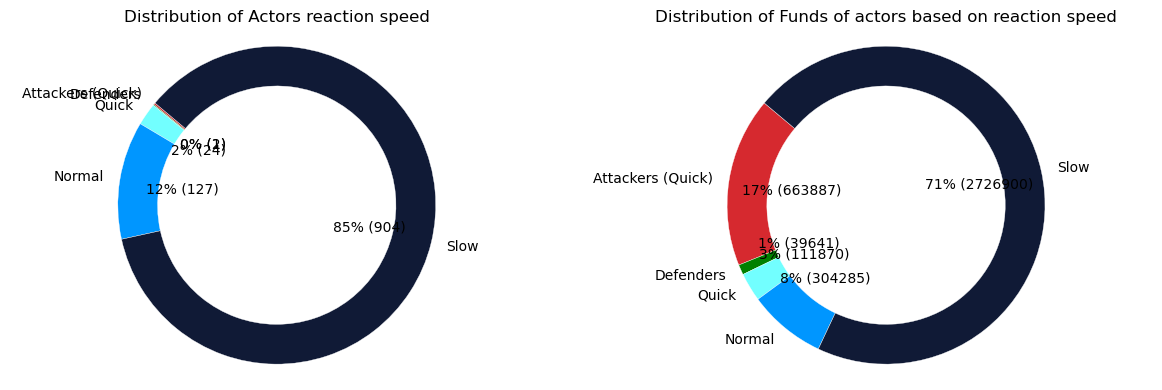

In [12]:
post_processing["total_quick_honest_actors_reaction_time"] = (
    post_processing["total_quick_actors_reaction_time"] - post_processing["total_attackers"]
)
post_processing["total_quick_honest_actors_funds"] = (
    post_processing["total_quick_actors_funds"] - post_processing["total_attackers_actors_funds"]
)

actors_distribution = generate_distribution(
    post_processing,
    ["Attackers (Quick)", "Defenders", "Quick", "Normal", "Slow"],
    [
        "total_attackers",
        "total_defenders",
        "total_quick_honest_actors_reaction_time",
        "total_normal_actors_reaction_time",
        "total_slow_actors_reaction_time",
    ],
    ["#D6292F", "green", "#72FFFF", "#0096FF", "#101A36"],
    "Distribution of Actors reaction speed",
)

funds_distribution = generate_distribution(
    post_processing,
    ["Attackers (Quick)", "Defenders", "Quick", "Normal", "Slow"],
    [
        "total_attackers_actors_funds",
        "total_defenders_actors_funds",
        "total_quick_honest_actors_funds",
        "total_normal_actors_funds",
        "total_slow_actors_funds",
    ],
    ["#D6292F", "green", "#72FFFF", "#0096FF", "#101A36"],
    "Distribution of Funds of actors based on reaction speed",
)

## add legend

fig = create_donut_charts(post_processing, [actors_distribution, funds_distribution], 0, TIMESTEPS)

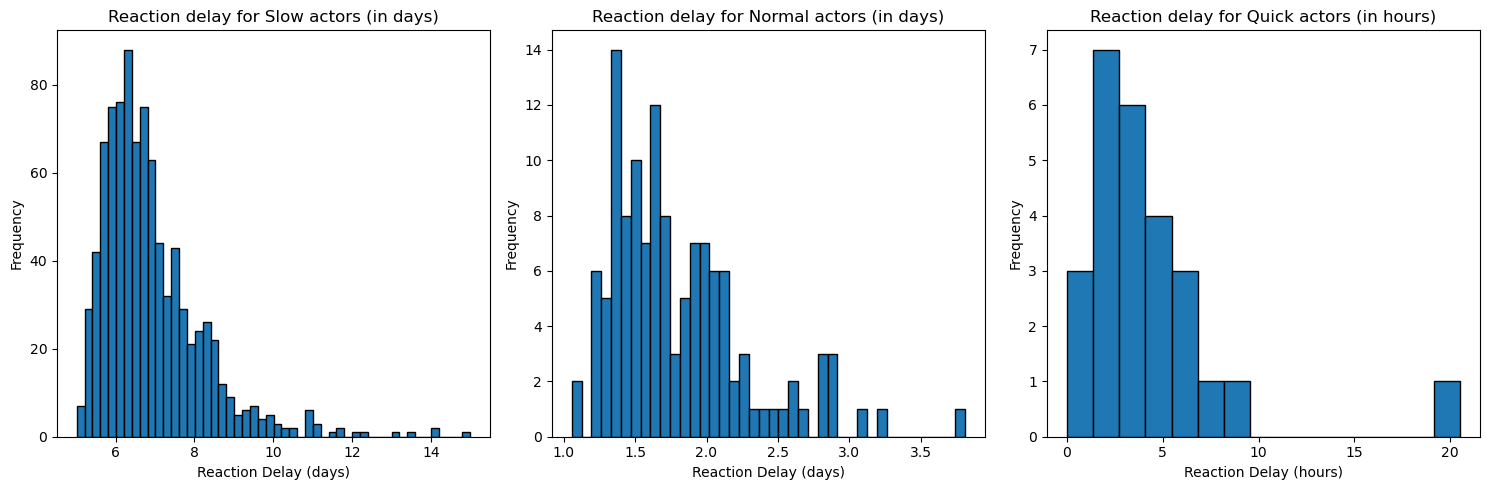

In [13]:
def plot_reaction_delay_histogram(actors_df, timestep, seed, reaction_times, time_units, bins_list):
    actors_end = actors_df[(actors_df["timestep"] == timestep) & (actors_df["seed"] == seed)].copy()
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, (reaction_time, bins) in enumerate(zip(reaction_times, bins_list)):
        reaction_delay_series = actors_end.loc[
            actors_end["reaction_time"] == "ReactionTime." + str(reaction_time), "reaction_delay"
        ]
        reaction_delay_series = reaction_delay_series.replace(9223372036854775807, 0)

        if time_units[i] == "minutes":
            reaction_delay_series_converted = reaction_delay_series / 60
            xlabel = "Reaction Delay (minutes)"
            title = f"Reaction delay for {reaction_time} actors (in minutes)"
        if time_units[i] == "hours":
            reaction_delay_series_converted = reaction_delay_series / 3600
            xlabel = "Reaction Delay (hours)"
            title = f"Reaction delay for {reaction_time} actors (in hours)"
        elif time_units[i] == "days":
            reaction_delay_series_converted = reaction_delay_series / (3600 * 24)
            xlabel = "Reaction Delay (days)"
            title = f"Reaction delay for {reaction_time} actors (in days)"
        else:
            raise ValueError("Invalid time unit. Use 'hours' or 'days'.")

        reaction_delay_series_converted.plot(kind="hist", bins=bins, edgecolor="black", ax=axes[i])
        axes[i].set_xlabel(xlabel)
        axes[i].set_ylabel("Frequency")
        axes[i].set_title(title)

    plt.tight_layout()
    plt.show()


plot_reaction_delay_histogram(
    actors_df, TIMESTEPS, SEED, ["Slow", "Normal", "Quick"], ["days", "days", "hours"], [50, 40, 15]
)
## add explanation about the distributions

#### Results Summary for Run 2

##### Time from maximum total health to maximum combined_percentage_locked: **30 hours** (1.25 days)

##### Maximum percentage of rage quit support : **3.93 %**

##### Maximum number of locked tokens : **204088.10 stETH** and **70202.44 wstETH**

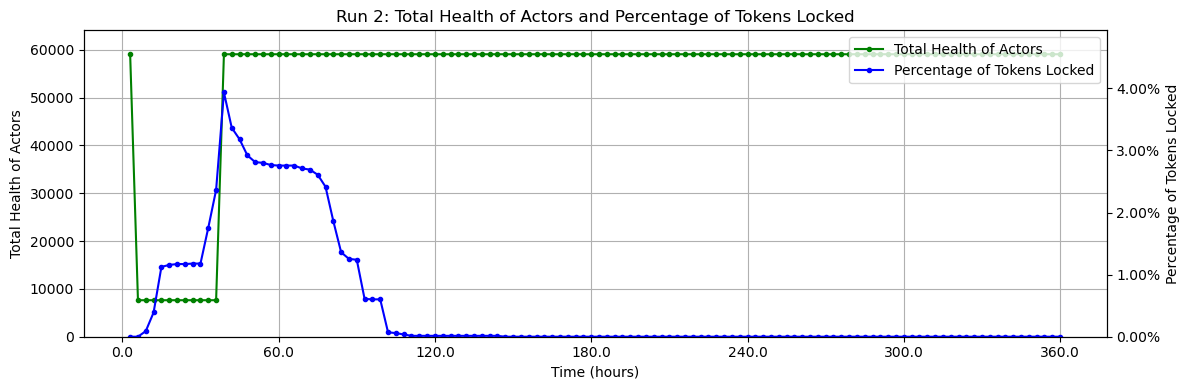

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import display, Markdown

start_idx = PRESENTED_RUN * TIMESTEPS
end_idx = start_idx + TIMESTEPS

total_stETH_balance = post_processing["total_stETH_balance"].iloc[start_idx:end_idx]
total_stETH_locked = post_processing["total_stETH_locked"].iloc[start_idx:end_idx]
total_wstETH_balance = post_processing["total_wstETH_balance"].iloc[start_idx:end_idx]
total_wstETH_locked = post_processing["total_wstETH_locked"].iloc[start_idx:end_idx]
total_actors_damaged = post_processing["total_actors_damaged"].iloc[start_idx:end_idx]
total_actors_health = post_processing["total_actors_health"].iloc[start_idx:end_idx]
total_actors_recovery = post_processing["total_actors_recovery"].iloc[start_idx:end_idx]
rage_quit_support = post_processing["rage_quit_support"].iloc[start_idx:end_idx]
timesteps = post_processing["timestep"].iloc[start_idx:end_idx]

combined_balance = total_stETH_balance + total_wstETH_balance + total_stETH_locked + total_wstETH_locked
combined_locked = total_stETH_locked + total_wstETH_locked

percentage_locked = [
    (locked / balance) if balance != 0 else 0 for locked, balance in zip(combined_locked, combined_balance)
]

max_total_health_idx = total_actors_health.idxmax()
max_total_health_ts = timesteps[max_total_health_idx]

max_combined_percentage_locked_idx = percentage_locked.index(max(percentage_locked))
max_combined_percentage_locked_ts = timesteps[start_idx + max_combined_percentage_locked_idx]

time_difference = max_combined_percentage_locked_ts - max_total_health_ts
time_difference_hours = time_difference * 3
time_difference_days = time_difference_hours / 24

display(Markdown(f"#### Results Summary for Run {PRESENTED_RUN + 1}"))
display(
    Markdown(
        f"##### Time from maximum total health to maximum combined_percentage_locked: **{time_difference_hours} hours** ({time_difference_days:.2f} days)"
    )
)
display(Markdown(f"##### Maximum percentage of rage quit support : **{rage_quit_support.max():.2f} %**"))
display(
    Markdown(
        f"##### Maximum number of locked tokens : **{total_stETH_locked.max():.2f} stETH** and **{total_wstETH_locked.max():.2f} wstETH**"
    )
)

fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot total_actors_health on the left y-axis
ax1.plot(timesteps, total_actors_health, color="green", label="Total Health of Actors", marker="o", markersize=3)
max_total_health = total_actors_health.max()
max_total_health_rounded = max_total_health + 5000

ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Total Health of Actors")
ax1.set_ylim(0, max_total_health_rounded)  # Set y-axis limit based on maximum health
ax1.yaxis.set_major_formatter(ticker.ScalarFormatter())

# Create a secondary y-axis for percentage_locked
ax2 = ax1.twinx()
ax2.plot(timesteps, percentage_locked, color="blue", label="Percentage of Tokens Locked", marker="o", markersize=3)
ax2.set_ylabel("Percentage of Tokens Locked")

# Calculate the maximum value of percentage_locked and set the y-axis limit
max_percentage_locked = max(percentage_locked)
max_percentage_locked_rounded = max_percentage_locked + 0.01
ax2.set_ylim(0, max_percentage_locked_rounded)
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper right")

ax1.set_title(f"Run {PRESENTED_RUN + 1}: Total Health of Actors and Percentage of Tokens Locked")
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))

plt.tight_layout()
plt.show()

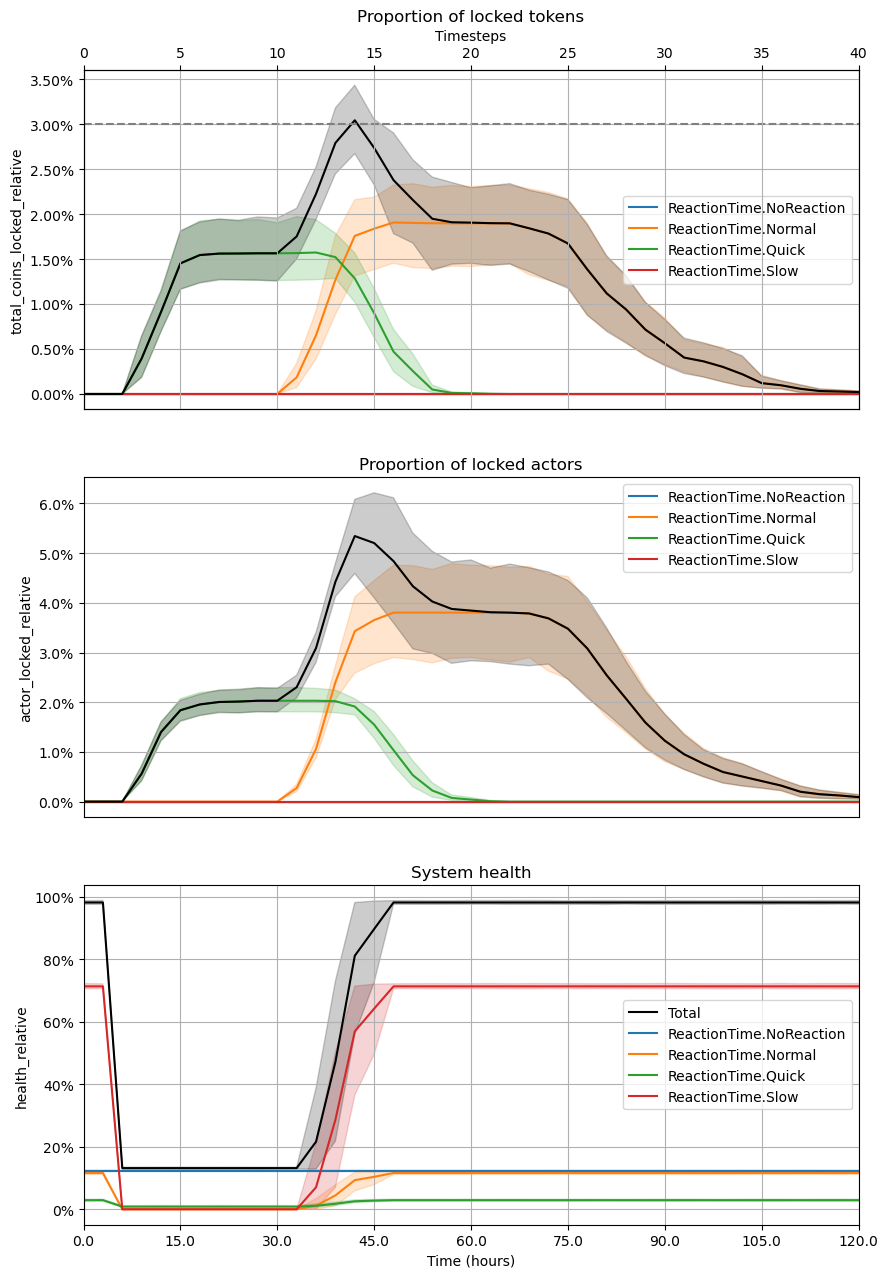

In [15]:
import seaborn as sns

ys = ("total_coins_locked_relative", "actor_locked_relative", "health_relative")
titles = ("Proportion of locked tokens", "Proportion of locked actors", "System health")

actors_df_summed_by_actors_rts = (
    actors_df.groupby(by=["seed", "timestep", "reaction_time"]).sum(numeric_only=True).reset_index()
)
actors_df_summed_by_actors = actors_df.groupby(by=["seed", "timestep"]).sum(numeric_only=True).reset_index()

basesize = 5
fig, axes = plt.subplots(figsize=(basesize * 2, basesize * len(ys)), nrows=len(ys), sharex=True)
for i, y in enumerate(ys):
    ax1 = axes[i]
    sns.lineplot(actors_df_summed_by_actors_rts, x="timestep", y=y, hue="reaction_time", ax=ax1)
    sns.lineplot(actors_df_summed_by_actors, x="timestep", y=y, ax=ax1, color="black")
    plt.plot([], [], color="black", label="Total")
    ax1.set_xlabel("Time (hours)")
    # ax1.set_ylim(0, 0.15)
    ax1.set_xlim(0, 40)
    ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x * 3}"))

    if y == "total_coins_locked_relative":
        xlim = ax1.get_xlim()
        ax1.plot(xlim, [0.03, 0.03], linestyle="--", color="gray", label="Veto signalling threshold")
        ax1.set_xlim(xlim)

    if i == 0:
        ax2 = ax1.twiny()
        ax2.grid(True)
        ax2.set_xlabel("Timesteps")
        ax2.set_xticks(ax1.get_xticks())
        ax2.set_xlim(ax1.get_xlim())
    ax1.grid(True)
    if i != len(ys) - 1:
        ax1.get_xaxis().set_visible(False)

    title = titles[i]
    ax1.set_title(title)

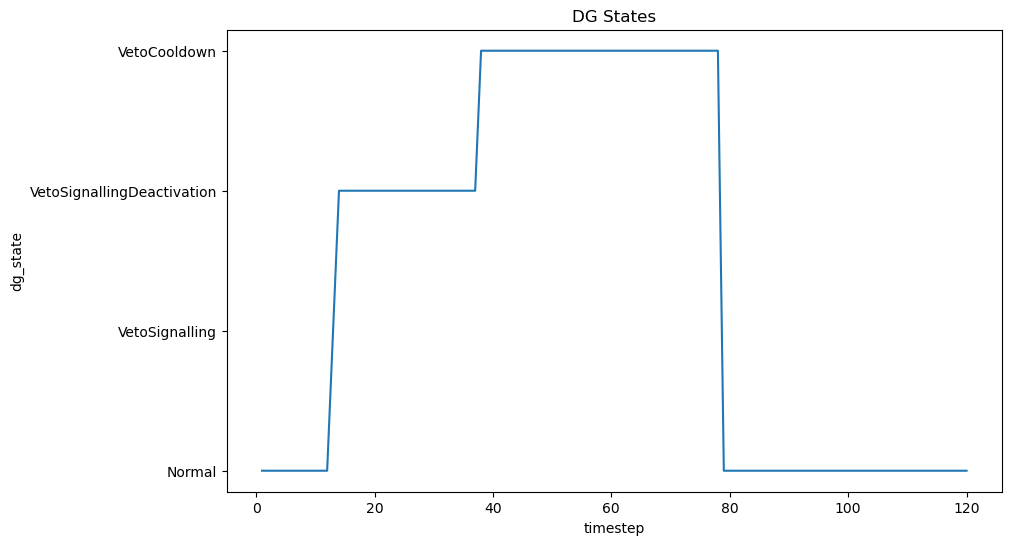

In [16]:
from specs.dual_governance.state import State


def state_plot(df, x, y, run):
    states = df[df.simulation == run][y].map(lambda r: State(r).name)
    plt.figure(figsize=(10, 6))
    plt.plot(df[df.simulation == run][x], states)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title("DG States")
    plt.show()


state_plot(post_processing, "timestep", "dg_state", PRESENTED_RUN)

In [17]:
display(simulation_hashes)

['ddc19fa0ff7d54692ee1c9befb7c0ef2fd553fc8bf2929ff92fedb2db67f537f-120',
 '8e1fe3674f69af0d4f911d52a10d1e6883876f3b048993203c662593eba991a6-120',
 '8dba00b64449e25847ddeff09ec5e5fc31d32dd601a6c0eb9247ab6b0e984260-120',
 '3e45e76d6aeeda33b71511ea9ff4230c32e8e52f1f72ce2b40223380a66f48cc-120',
 'ae9e78dd1d4d22fa139f3f5bfd4b414e80e86819f3d0ab2c085898b56bf00d2d-120',
 'f09e2cf4e662e666b89d411b22337130fe19f1f5c48451ddc77db0ce0993ef8c-120',
 '257f47571e4edc8dada3e6e8b4cc841e8be8c2e5261699f2ebd197fbfefbf378-120',
 'acd7211046fed6764faa8486de2223740fbd8e64436dcfa39033d8d42f6696ec-120',
 '9a8b4998d158469e603a0d8bc04235bb0960ebde8d288cee64af88a3b72124e7-120',
 '863801e87f1db67386e391555002055cd867f4a9b8bbec647d2ca3cb705d34fa-120']